In [1]:
import os.path

import gpytorch
import latextable
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from func_algorithms import *
from func_data_generation import *
from func_polygon import *
from matplotlib import font_manager
from matplotlib.gridspec import GridSpec
from texttable import Texttable
from torch import nn
from torchsummary import summary
from utils import *
from warp_units import *

dtype = torch.double
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

torch.set_default_dtype(dtype)
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using cuda device


## 改写Data1_new的free_path

In [323]:
seed = 13
grid_res = 180
tran_power = 30
choose_num = 500
sigma_noise = 0.2

# generate trans_location
torch.manual_seed(seed)
tran_x = torch.rand(()) * 1000
tran_y = -torch.rand(()) * 1000
tran_loc = torch.stack((tran_x, tran_y), dim=-1)
coords_2, free_path_2 = get_field_data(
    grid_res, tran_power, tran_loc, device, r_η=4.5, fc=700e6
)
free_path = free_path_2.to("cpu").numpy()

file = DATA_PATH + "/datasets_1-new" + ".hd5f"

with h5py.File(file, "a") as f:
    f["free_path"][...] = free_path

## 载入数据：

In [326]:
data_num = 1
sensor_num = 500  # [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]


# data_filename = DATA_PATH + "/datasets_" + str(data_num) + ".hd5f"
data_filename = DATA_PATH + "/datasets_1-new" + ".hd5f"

if os.path.exists(data_filename):
    with h5py.File(data_filename, "r") as f1:
        coords = f1["coords"][...]
        free_path = f1["free_path"][...]
        shadow = f1["shadow"][...]
        noise = f1["noise"][...]
        train_X = f1["train_" + str(sensor_num) + "/train_X"][...]
        train_y = f1["train_" + str(sensor_num) + "/train_y"][...]
        idx = f1["train_" + str(sensor_num) + "/idx"][...]

In [354]:
def cdzr_fazr(thresh, true_rem, predicted_rem):
    MD = np.logical_and(true_rem > thresh, predicted_rem < thresh).sum()
    CD1 = np.logical_and(true_rem > thresh, predicted_rem > thresh).sum()
    CD0 = np.logical_and(true_rem < thresh, predicted_rem < thresh).sum()
    FA = np.logical_and(true_rem < thresh, predicted_rem > thresh).sum()
    #     print(FA)

    CDZR = CD1 / (CD1 + MD)
    FAZR = FA / (CD0 + FA)
    return CDZR, FAZR

In [355]:
def get_cdzr(sensor_nums):

    data_filename = DATA_PATH + "/datasets_1-new" + ".hd5f"

    if os.path.exists(data_filename):
        with h5py.File(data_filename, "r") as f1:
            coords = f1["coords"][...]
            free_path = f1["free_path"][...]
            shadow = f1["shadow"][...]
            noise = f1["noise"][...]
    true_rss = free_path + shadow
    length = len(sensor_nums)
    nn_cdzr = np.zeros((length))
    nn_fazr = np.zeros((length))
    idwnn_cdzr = np.zeros((length))
    idwnn_fazr = np.zeros((length))
    ok_cdzr = np.zeros((length))
    ok_fazr = np.zeros((length))
    gp_cdzr = np.zeros((length))
    gp_fazr = np.zeros((length))
    warpgp_cdzr = np.zeros((length))
    warpgp_fazr = np.zeros((length))

    result_filename = DATA_PATH + "/result_1" + ".hd5f"

    for i, num in enumerate(sensor_nums):
        with h5py.File(data_filename, "r") as f1:
            train_X = f1["train_" + str(num) + "/train_X"][...]
            train_y = f1["train_" + str(num) + "/train_y"][...]
            idx = f1["train_" + str(num) + "/idx"][...]

        predict_nn = k_nearest_neighbor(train_X, train_y, coords, 20)
        predict_idwnn = k_nearest_neighbor(
            train_X, train_y, coords, 20, weights="distance"
        )
        predict_ok_mean, predict_ok_var = ok(train_X, train_y, coords)

        if os.path.exists(result_filename):
            with h5py.File(result_filename, "r") as f2:
                if "gp" in f2:
                    if str(num) in f2["gp"]:
                        predict_gp_mean = f2["/gp/" + str(num) + "/predict_mean"][...]
                        predict_gp_var = f2["/gp/" + str(num) + "/predict_var"][...]

                if "dgp" in f2:
                    if str(num) in f2["dgp"]:
                        predict_dgp_mean = f2["/dgp/" + str(num) + "/predict_mean"][...]
                        predict_dgp_var = f2["/dgp/" + str(num) + "/predict_var"][...]

                if "warpgp" in f2:
                    if str(num) in f2["warpgp"]:
                        predict_warpgp_mean = f2[
                            "/warpgp/" + str(num) + "/predict_mean"
                        ][...]
                        predict_warpgp_var = f2["/warpgp/" + str(num) + "/predict_var"][
                            ...
                        ]

        nn_cdzr[i], nn_fazr[i] = cdzr_fazr(-114, true_rss, predict_nn + free_path)
        idwnn_cdzr[i], idwnn_fazr[i] = cdzr_fazr(
            -114, true_rss, predict_idwnn + free_path
        )
        ok_cdzr[i], ok_fazr[i] = cdzr_fazr(-114, true_rss, predict_ok_mean + free_path)
        gp_cdzr[i], gp_fazr[i] = cdzr_fazr(-114, true_rss, predict_gp_mean + free_path)
        warpgp_cdzr[i], warpgp_fazr[i] = cdzr_fazr(
            -114, true_rss, predict_warpgp_mean + free_path
        )
        cdzr = {
            "nn": nn_cdzr,
            "idwnn": idwnn_cdzr,
            "ok": ok_cdzr,
            "gp": gp_cdzr,
            "warpgp": warpgp_cdzr,
        }
        fazr = {
            "nn": nn_fazr,
            "idwnn": idwnn_fazr,
            "ok": ok_fazr,
            "gp": gp_fazr,
            "warpgp": warpgp_fazr,
        }
    return cdzr, fazr

In [356]:
cdzr, fazr = get_cdzr(range(200, 801, 50))

KeyError: 'Unable to open object (component not found)'

In [340]:
print(fazr)

{'nn': array([0.02812758, 0.02761148, 0.02895334, 0.02461808, 0.02183113,
       0.02126342, 0.0176507 , 0.01754748, 0.01625723, 0.0146057 ,
       0.01424443, 0.01357349, 0.01248968]), 'idwnn': array([0.02126342, 0.02002477, 0.0196635 , 0.01728943, 0.01481214,
       0.01419282, 0.01181874, 0.01187036, 0.01088976, 0.01021883,
       0.01016722, 0.01001239, 0.00918662]), 'ok': array([0.01047688, 0.00965111, 0.00748348, 0.00670933, 0.00490297,
       0.00459331, 0.00412882, 0.00392238, 0.00387077, 0.00381916,
       0.00330306, 0.00330306, 0.00273534]), 'gp': array([0.00939306, 0.01073493, 0.00846408, 0.00794798, 0.00634806,
       0.00645128, 0.00665772, 0.00619323, 0.00464492, 0.00578035,
       0.00443848, 0.00376755, 0.00412882]), 'warpgp': array([0.01088976, 0.01357349, 0.01692816, 0.00990917, 0.0095995 ,
       0.00758671, 0.0085673 , 0.00748348, 0.00712221, 0.00670933,
       0.0050578 , 0.00598679, 0.00536746])}


In [396]:
def plot_rantio_num(r_dict, sensor_nums):
    with plt.style.context(["science", "ieee", "no-latex", "grid"]):
        figure, ax = plt.subplots()
        ax.plot(
            sensor_nums,
            r_dict["nn"],
            label="NN",
            ls="-",
            marker="x",
            c="b",
            linewidth=0.5,
            markersize=3,
        )
        ax.plot(
            sensor_nums,
            r_dict["idwnn"],
            label="IDWNN",
            ls=":",
            marker="+",
            c="g",
            linewidth=0.5,
            markersize=3,
        )
        ax.plot(
            sensor_nums,
            r_dict["ok"],
            label="OK",
            ls="-.",
            marker="o",
            c="c",
            linewidth=0.5,
            markersize=2,
            markerfacecolor="None",
        )
        ax.plot(
            sensor_nums,
            r_dict["gp"],
            label="GP",
            ls="--",
            marker="s",
            c="m",
            linewidth=0.5,
            markersize=2,
            markerfacecolor="None",
        )
        ax.plot(
            sensor_nums,
            r_dict["warpgp"],
            label="TKL",
            ls="-",
            marker="v",
            c="r",
            linewidth=0.5,
            markersize=2,
            markerfacecolor="None",
        )
        #         ax.plot(sensor_nums, nn_mape, marker=".", label="NN")
        #         ax.plot(sensor_nums, idwnn_mape, marker="s", label="IWD NN")
        #         ax.plot(sensor_nums, ok_mape, marker="x", label="OK")
        ax.set_xlabel("群智感知设备数量", font="STSong")
#         ax.set_ylabel("第一类正确判决区域比例", font="STSong")
        ax.set_ylabel("虚警区域比例", font="STSong")
        ax.legend(fontsize=6, labelspacing=0.25)

Saving figure cdzr_cn


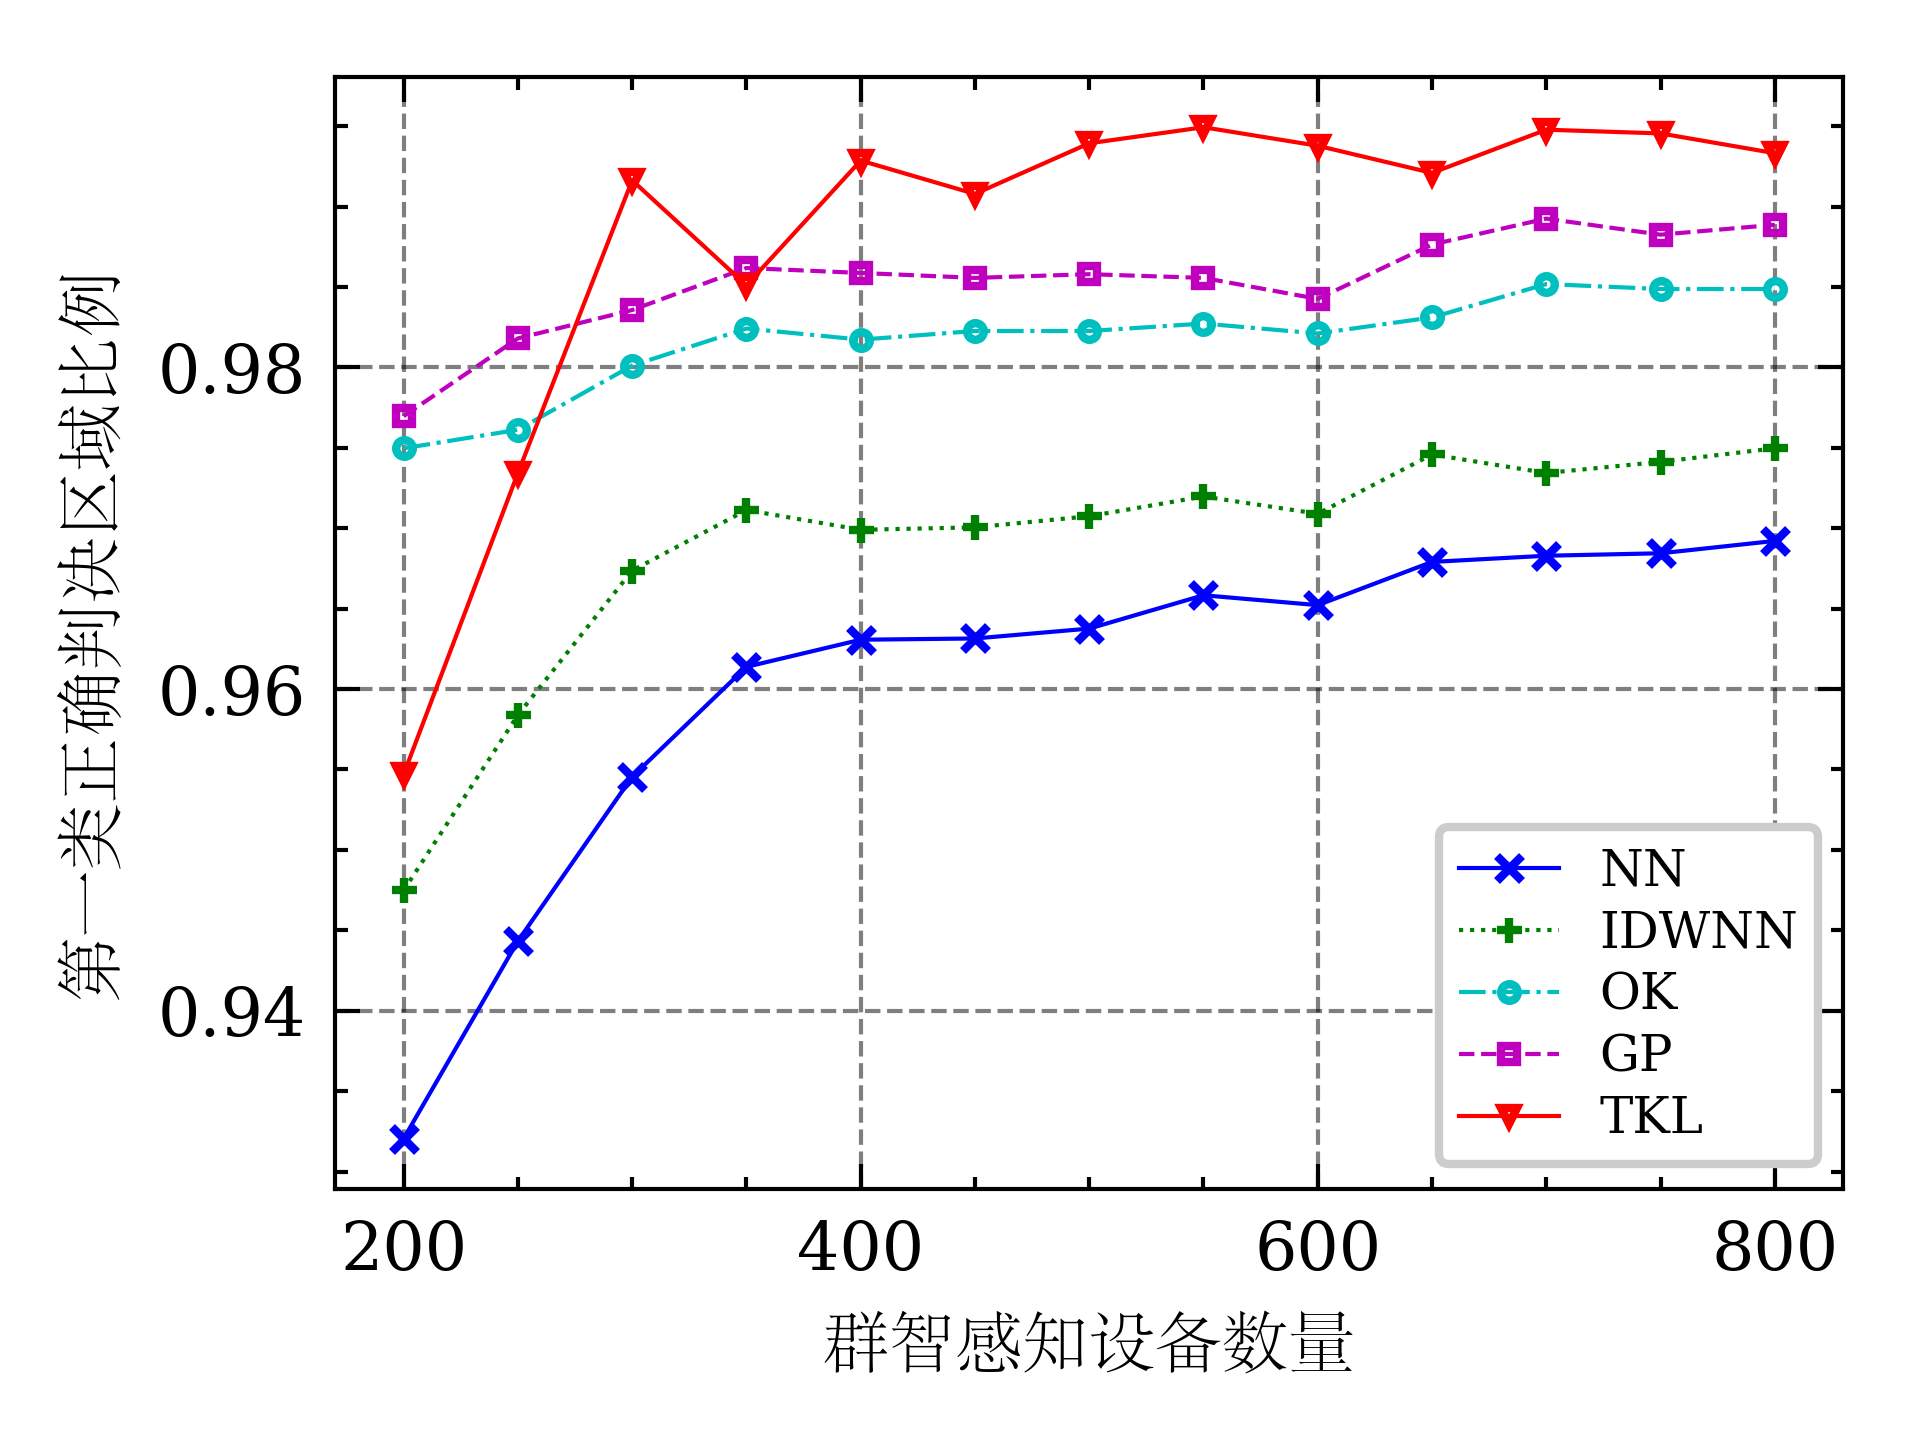

In [395]:
plot_rantio_num(cdzr, range(200, 801, 50))
save_fig("cdzr_cn", fig_extension="svg")

Saving figure fazr_cn


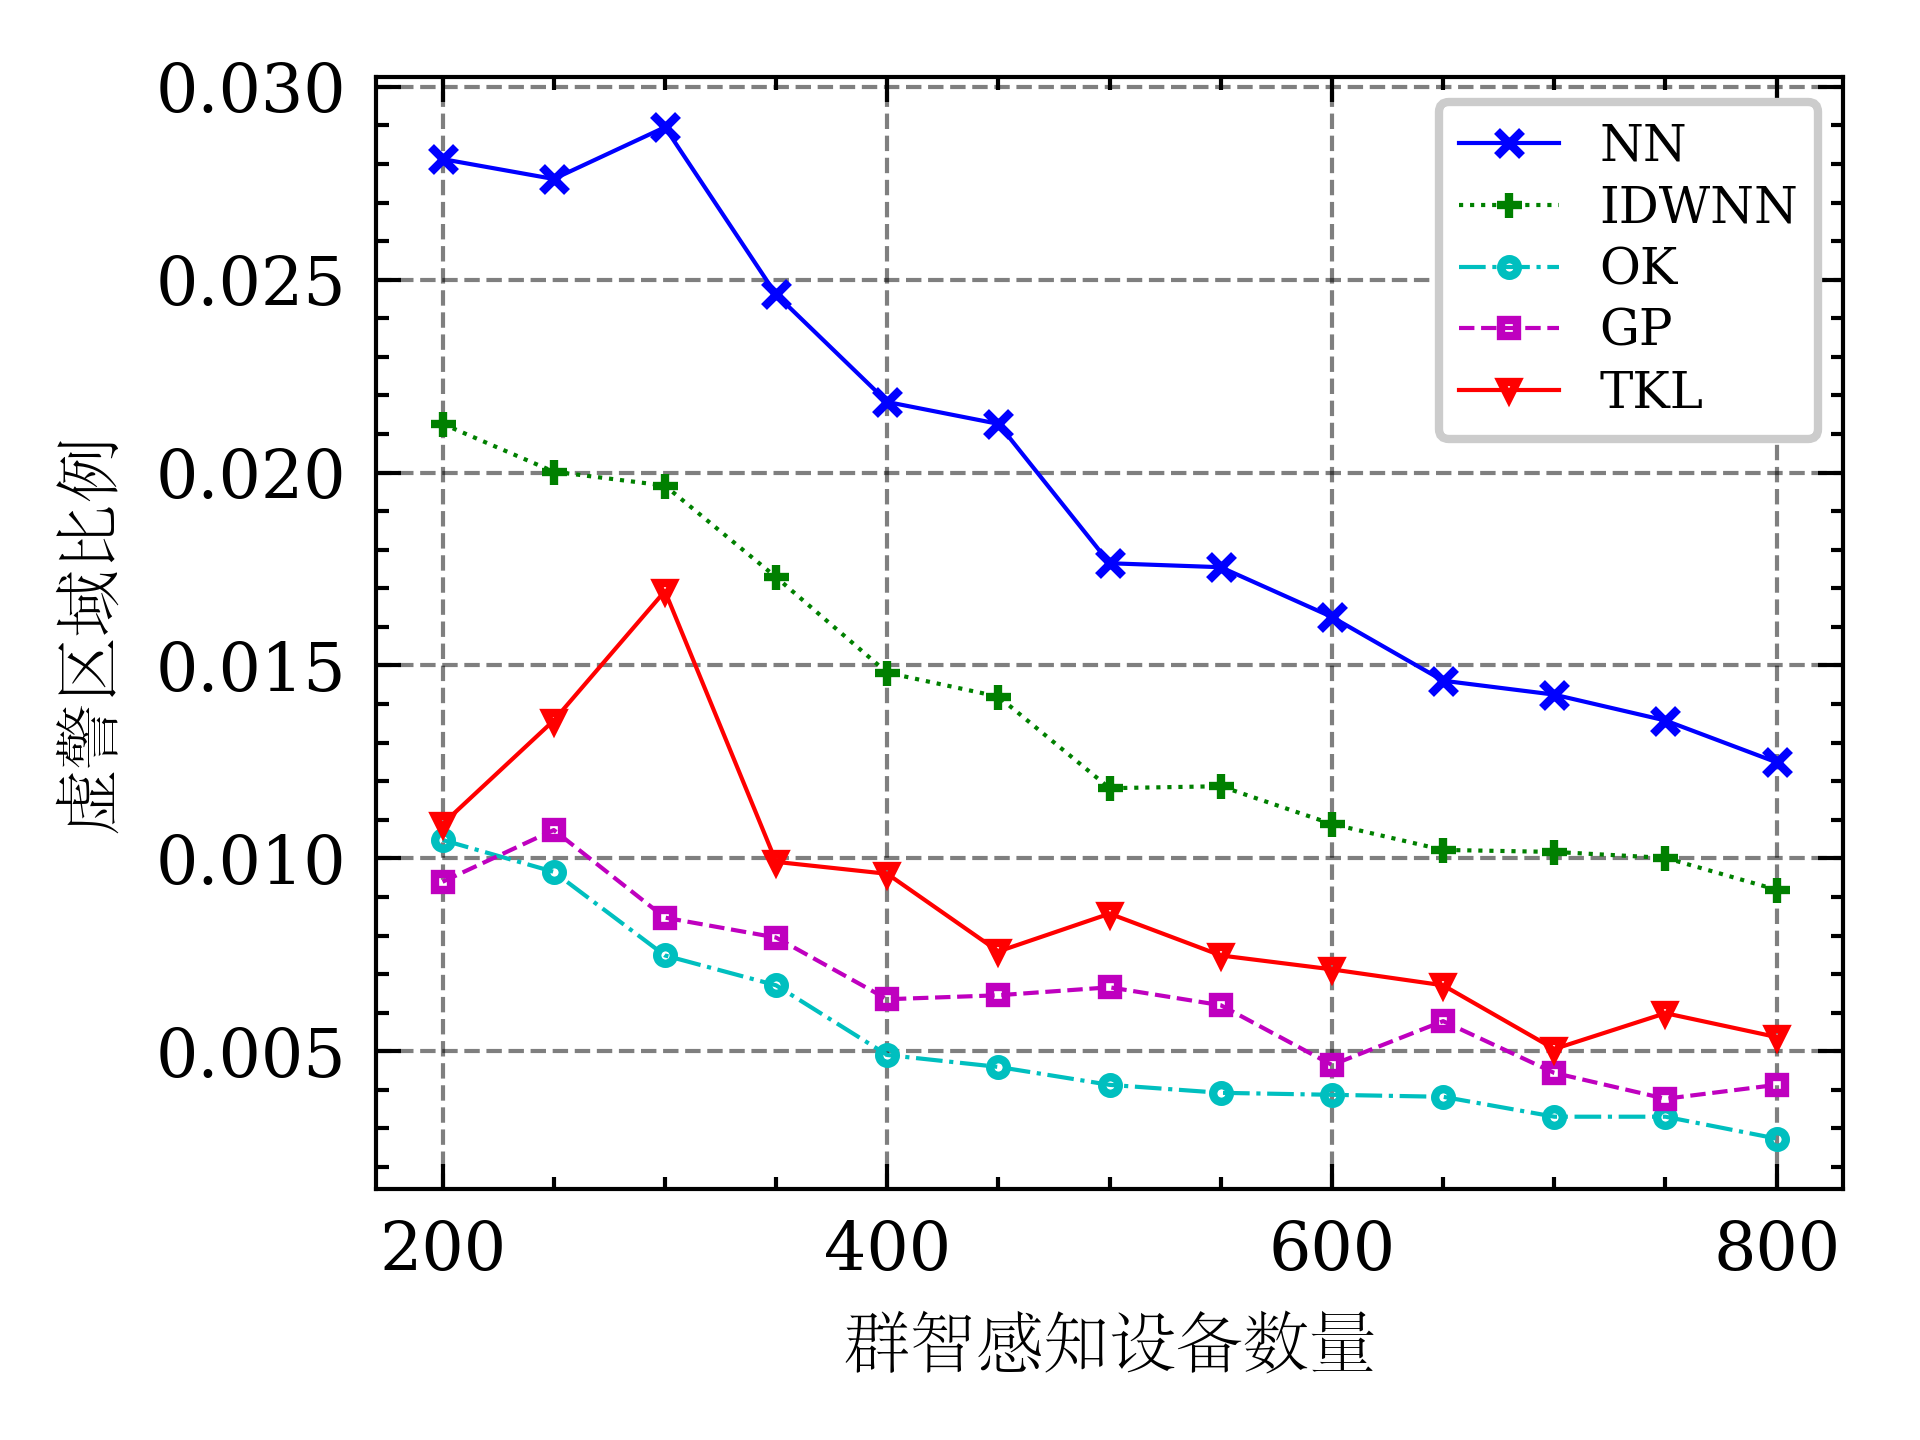

In [397]:
plot_rantio_num(fazr, range(200, 801, 50))
save_fig("fazr_cn", fig_extension="svg")

In [351]:
def plot_roc(fazr_dict, cdzr_dict):
    with plt.style.context(["science", "ieee", "no-latex", "grid"]):
        figure, ax = plt.subplots()
        ax.plot(
            fazr_dict["nn"],
            cdzr_dict["nn"],
            label="NN",
            ls="-",
            marker="x",
            c="b",
            linewidth=0.5,
            markersize=3,
        )
        ax.plot(
            fazr_dict["idwnn"],
            cdzr_dict["idwnn"],
            label="IDWNN",
            ls=":",
            marker="+",
            c="g",
            linewidth=0.5,
            markersize=3,
        )
        ax.plot(
            fazr_dict["ok"],
            cdzr_dict["ok"],
            label="OK",
            ls="-.",
            marker="o",
            c="c",
            linewidth=0.5,
            markersize=2,
            markerfacecolor="None",
        )
        ax.plot(
            fazr_dict["gp"],
            cdzr_dict["gp"],
            label="GP",
            ls="--",
            marker="s",
            c="m",
            linewidth=0.5,
            markersize=2,
            markerfacecolor="None",
        )
        ax.plot(
            fazr_dict["warpgp"],
            cdzr_dict["warpgp"],
            label="TKL",
            ls="-",
            marker="v",
            c="r",
            linewidth=0.5,
            markersize=2,
            markerfacecolor="None",
        )
        #         ax.plot(sensor_nums, nn_mape, marker=".", label="NN")
        #         ax.plot(sensor_nums, idwnn_mape, marker="s", label="IWD NN")
        #         ax.plot(sensor_nums, ok_mape, marker="x", label="OK")
        ax.set_xlabel("Number of Crowd-sourced Sensors")
        ax.set_ylabel("RMSE")
        ax.legend(fontsize=6, labelspacing=0.25)

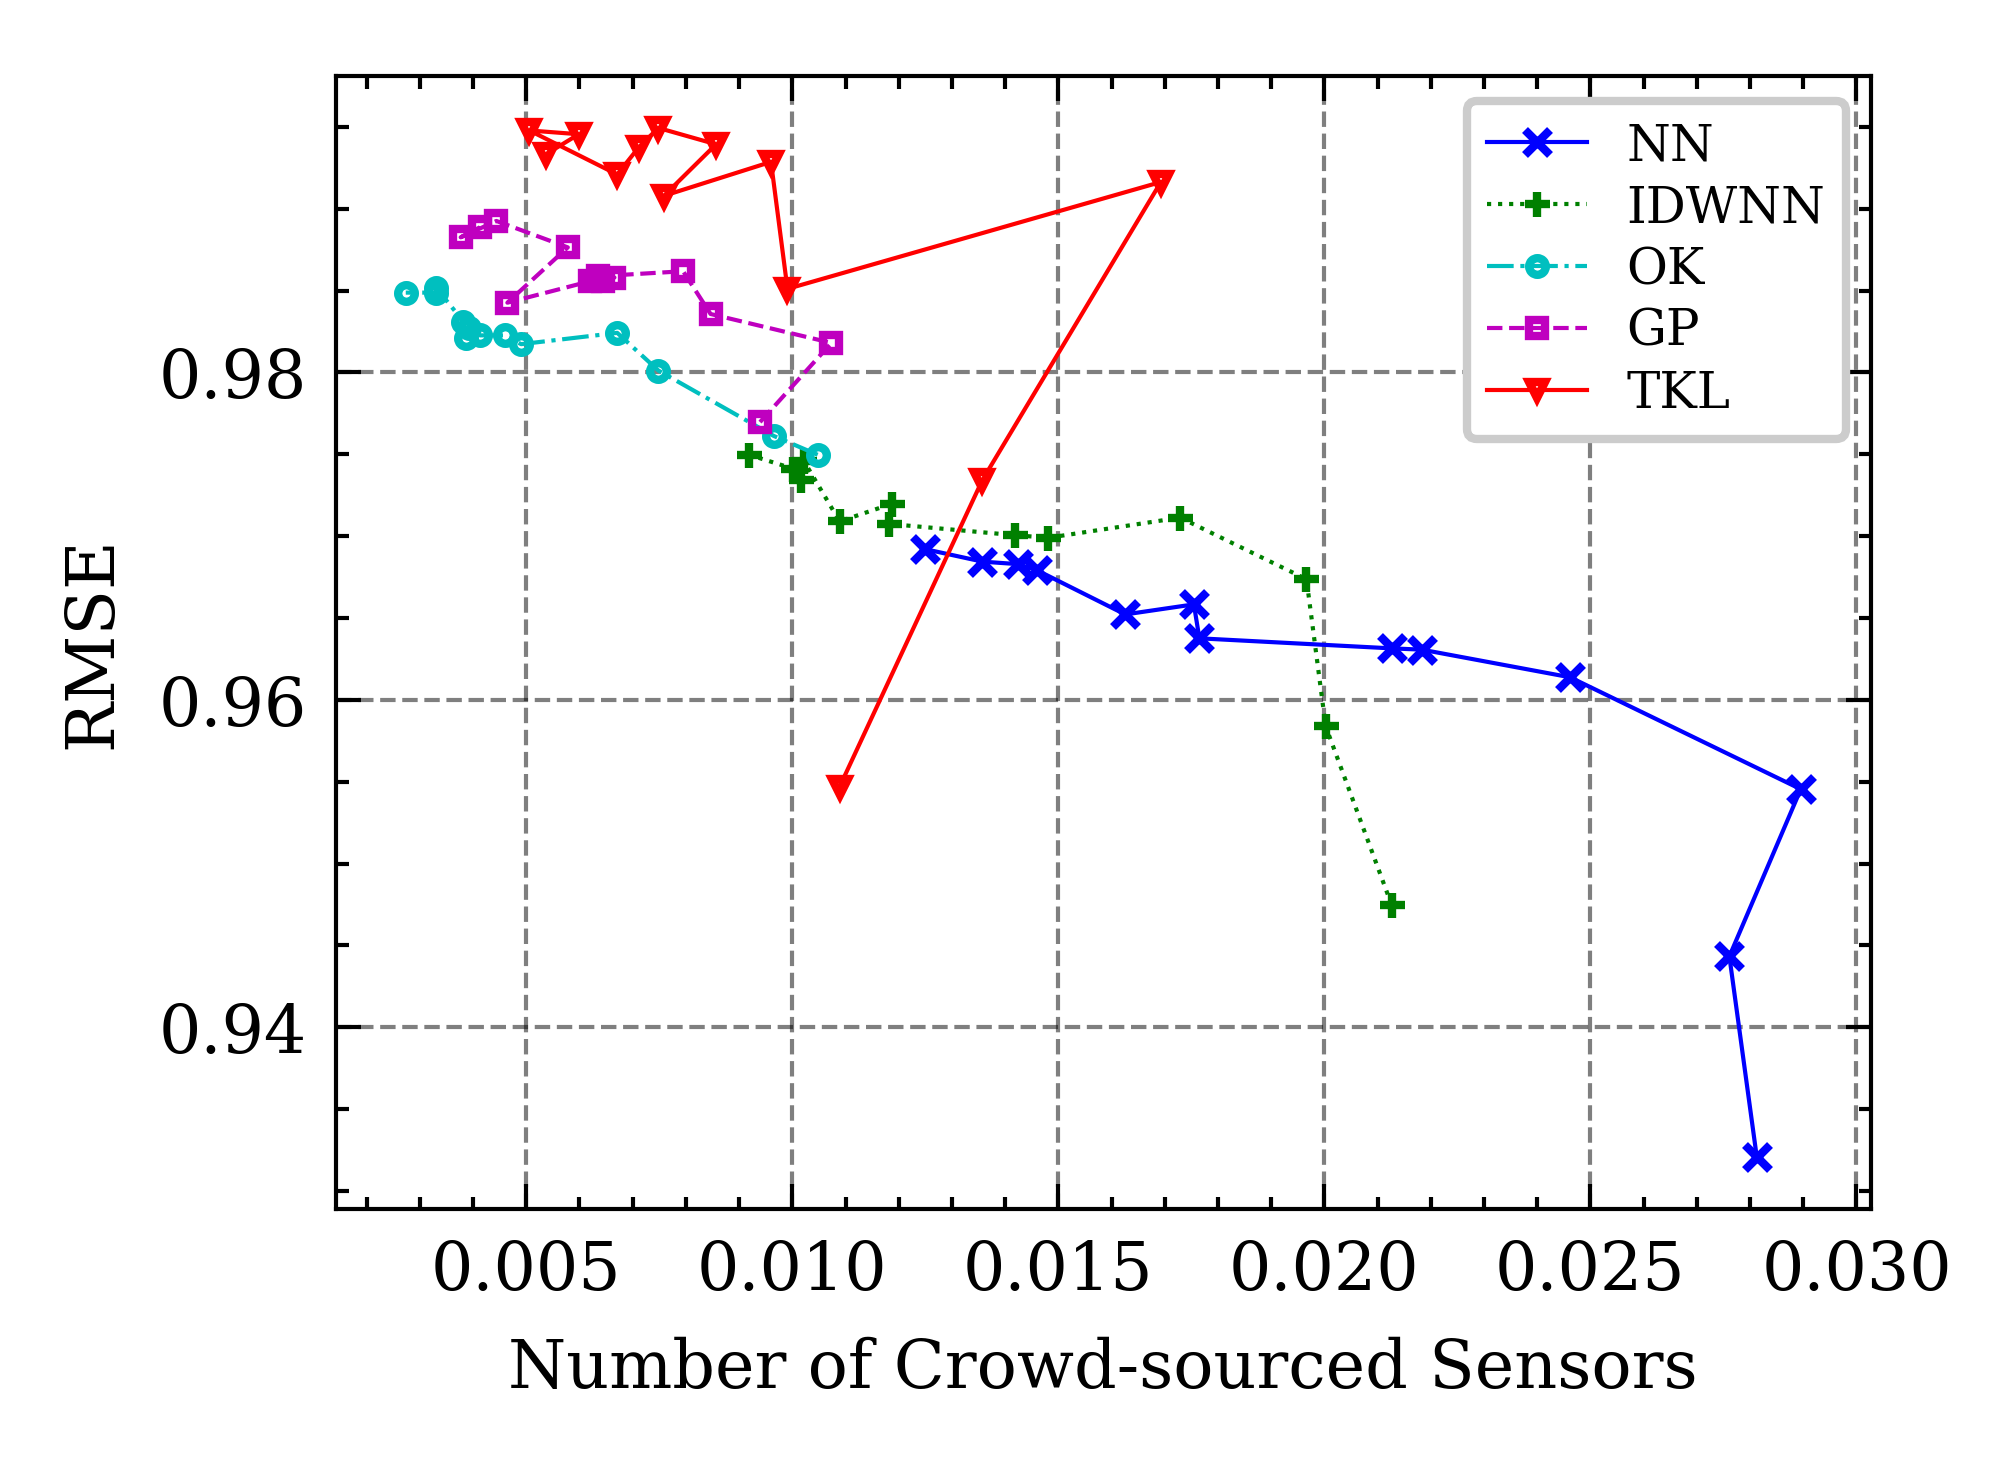

In [352]:
plot_roc(fazr, cdzr)

In [21]:
predict_nn = k_nearest_neighbor(train_X, train_y, coords, 20)
predict_iwdnn = k_nearest_neighbor(train_X, train_y, coords, 20, weights="distance")
predict_ok_mean, predict_ok_var = ok(train_X, train_y, coords)
predict_uk_mean, predict_uk_var = uk(train_X, train_y, coords)

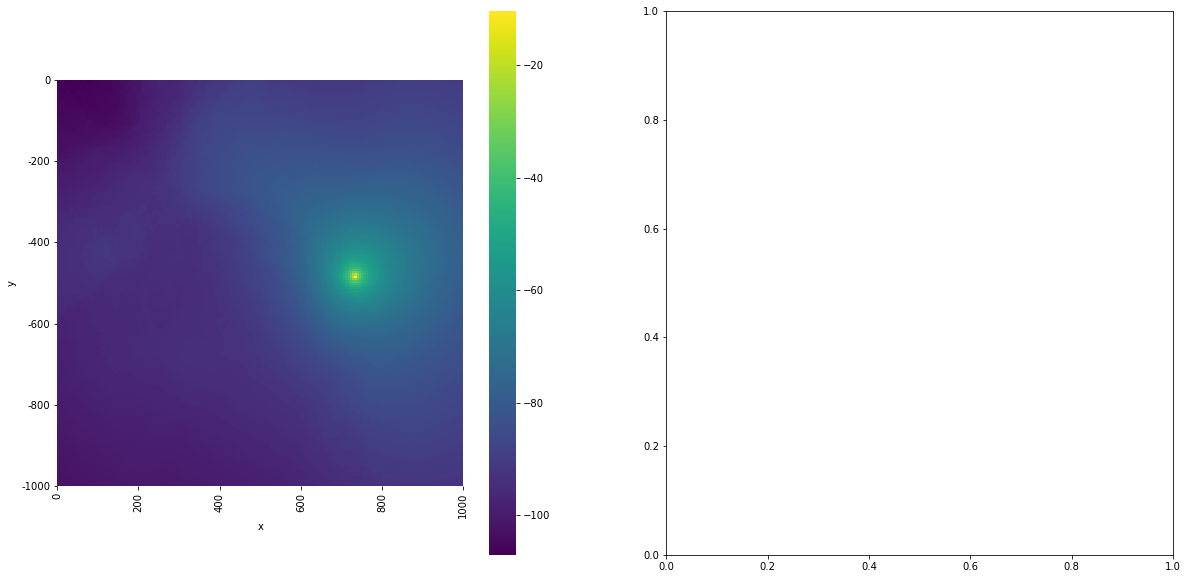

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_heatmap(
    coords,
    predict_nn + free_path,
    ax=axes[0],
    cbar=True,
)

In [328]:
nn_rss = predict_ok_mean + free_path

In [25]:
rem_nn = nn_rss > -80

In [30]:
np.logical_and

array([False, False, False, ..., False, False, False])

In [358]:
result_filename = DATA_PATH + "/result_1" + ".hd5f"
num = 600

if os.path.exists(result_filename):
    with h5py.File(result_filename, "r") as f2:
        #         if "gp" in f2:
        #             if str(num) in f2["gp"]:
        #                 predict_gp_mean = f2["/gp/" + str(num) + "/predict_mean"][...]
        #                 predict_gp_var = f2["/gp/" + str(num) + "/predict_var"][...]

        #         if "dgp" in f2:
        #             if str(num) in f2["dgp"]:
        #                 predict_dgp_mean = f2["/dgp/" + str(num) + "/predict_mean"][...]
        #                 predict_dgp_var = f2["/dgp/" + str(num) + "/predict_var"][...]

        if "warpgp" in f2:
            if str(num) in f2["warpgp"]:
                predict_warpgp_mean = f2["/warpgp/" + str(num) + "/predict_mean"][...]
                predict_warpgp_var = f2["/warpgp/" + str(num) + "/predict_var"][...]

In [367]:
vfun = np.vectorize(cdzr_fazr, excluded=[1, 2])

In [380]:
a = np.linspace(-125, -102, 10)

In [381]:
y, x = vfun(a, true_rss, predict_warpgp_mean + free_path)

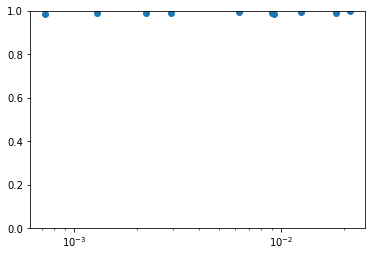

In [392]:
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_ylim((0, 1))
# ax.set_xlim((e-4, 1))
ax.set_xscale("log")

In [299]:
bbb = aaa[np.lexsort(np.fliplr(aaa).T)]
bbb_a = bbb.T

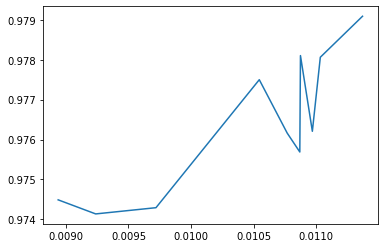

In [300]:
plt.plot(bbb_a[0, :], bbb_a[1, :])

In [293]:
dtype = [("cdzr", float), ("fazr", float)]
aaa_str = np.array(aaa, dtype=dtype)  # create a structured array
# aaa_sorted = np.sort(aaa_str, order="fazr")

In [198]:
aaa_str

array([[(0.07678729, 0.07678729), (0.99379439, 0.99379439)],
       [(0.06270062, 0.06270062), (0.99188517, 0.99188517)],
       [(0.04450478, 0.04450478), (0.98629278, 0.98629278)],
       [(0.01914441, 0.01914441), (0.98594408, 0.98594408)],
       [(0.01632868, 0.01632868), (0.97983965, 0.97983965)],
       [(0.00912941, 0.00912941), (0.97474854, 0.97474854)],
       [(0.00598888, 0.00598888), (0.96868494, 0.96868494)],
       [(0.00370323, 0.00370323), (0.98507137, 0.98507137)],
       [(0.00267049, 0.00267049), (0.98714266, 0.98714266)],
       [(0.00198927, 0.00198927), (0.98332465, 0.98332465)]],
      dtype=[('cdzr', '<f8'), ('fazr', '<f8')])

In [106]:
np.logical_and(true_rss > -80, nn_rss < -80).sum()

317

In [107]:
np.logical_and(true_rss > -80, nn_rss > -80).sum()

5440

In [62]:
tran_loc

tensor([ 734.5365, -484.4107])

In [73]:
coords_2, free_path_2 = get_field_data(
    grid_res, tran_power, tran_loc, device, r_η=4.5, fc=700e6
)

In [74]:
free_path

array([-102.33202081, -102.25138036, -102.17049956, ...,  -95.83122738,
        -95.89677704,  -95.96317949])

In [77]:
free_path2 = free_path_2.to("cpu").numpy()

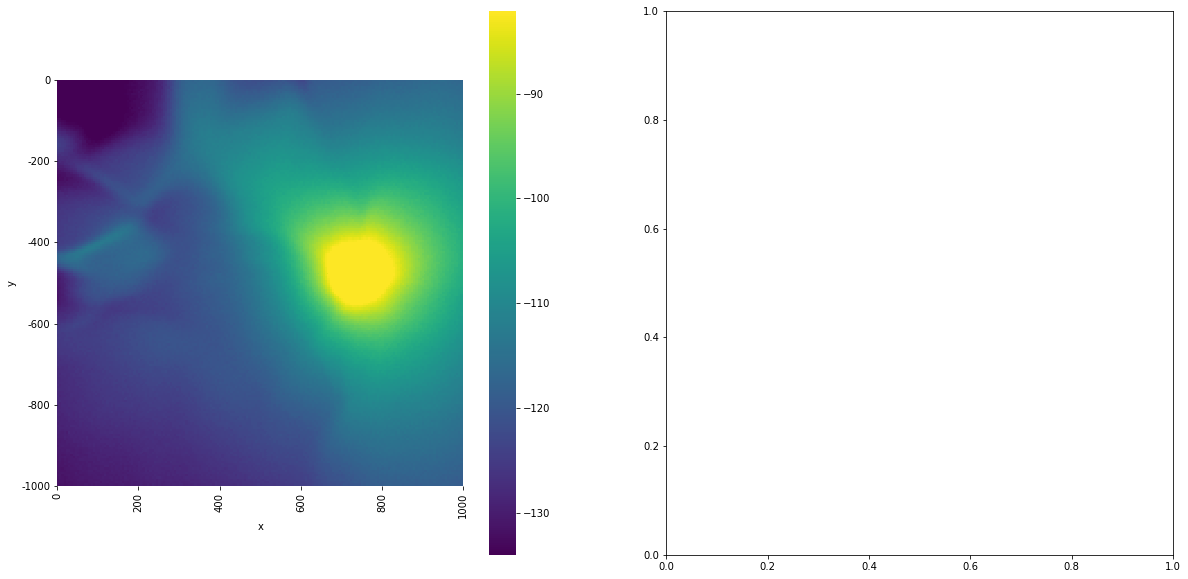

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_heatmap(coords, free_path2 + shadow + noise, ax=axes[0], cbar=True, robust=True)